# Vmat2-Cre Somatosensory Cortex Analysis
Here we are invesigating the molecular properties of 151 somatosensory cortical Vmat2-Cre;tdTomato cells from two animals. The single-cell data was aquired through Smartseq2. The following analysis is included in this paper; https://www.nature.com/articles/s41598-021-82649-8

The histological and electrophysical findings of our article showed that the Vmat2-Cre:tdTomato population is mainly excitatory and located in mainly the barrel area of layer IV in the somatosensory cortex. In this analysis, we wanted to verify these findings and further examine the Vmat2-Cre:tdTomato population on a molecular level. Here, we wanted to see if there are any subgroups of Vmat2-Cre neurons that could be defined by specific gene expression (top differential expressed genes) and if the Vmat2-Cre population expresses target genes for serotinergic synthesis and release, excitatory and inhibitory properties and if they showed distinct expression for cortical layer markers defined by Zeisel et al. (2018, [1]).

To further validate the Vmat2-Cre location on a molecular level, we aligned our Vmat2-Cre dataset to the cortical dataset published by Zeisel et al (2018, [1]) (for dataset, go to: http://mousebrain.org/loomfiles_level_L6.html, 'telencephalon excitatory projection neurons')by correcting for batch effects using the mutual nearest neighbor (MNN) algoritm (Haghverdi et al., 2016, [2]). We further mapped the probable location and cluster annotations defined by Zeisel et to our Vmat2-Cre dataset to get an insight to cortical layer location and cluster belonging.






References;


[1] Zeisel, A., Hochgerner, H., Lönnerberg, P. et al. (2018). Molecular Architecture of the Mouse Nervous System. Cell, doi: 10.1016/j.cell.2018.06.021

[2] Haghverdi, L., Büttner, M., Wolf, F.A. et al. (2016). Diffusion pseudotime robustly reconstructs branching cellular lineages. Nature methods, 8:845-848

[3] Traag, V.A., Waltman, L., van Eck, N.J., (2018). From Louvain to Leiden: guaranteeing well-connected communities. Scientific Reports, 9: 5233

[4] Harris, J.A., Hirokawa, K.E., Sorensen, S.A., Gu, H., Mills, M., Ng, L.L., Bohn, P., Mortrud, M., Ouellette, B., Kidney, J., et al. (2014). Anatomical characterization of Cre driver mice for neural circuit mapping and manipulation. Front Neural Circuits 8, 76.

In [1]:
# import necessary modules 
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import loompy

# make the text in figures editable in Illustrator
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

The following functions were used in the analysis

In [2]:
"""function for calculating the percentage of cells expressing gene of interest"""
def percentage_exp(adata, genes):
    per_list = []
    for gene in genes:
        percentage = len(adata[adata[:, gene].X > 0.25])/len(adata.X) # calculate the percentage of cells expressing gene(s) of interest
        per_list.append((gene, percentage*100)) # add the name of gene and the percentage to list
    return sorted(per_list, key=lambda tup: tup[1], reverse = True) #rank the level of prevalence in list

"""function for calculating the number of cells expressing gene of interest"""
def number_exp(adata, genes):
    num_list = []
    for gene in genes:
        percentage = len(adata[adata[:, gene].X > 0.25])/len(adata.X)# calculate the percentage of cells expressing gene(s) of interest
        num_list.append((gene, percentage*len(adata.X))) # add the name of gene and the number of cells expressing gene of intererest
    return sorted(num_list, key=lambda tup: tup[1], reverse = True) #rank the level of prevalence in list

##
"""function for extracting the genes of interest depending on the category of receptor type from Guide to Pharmacology 'targets_and_families.csv'"""
def rec_type_list(prot_df, rec_type):
    prot_df = prot_df[prot_df['Type'] == rec_type] #isolate the data having the receptor type of interest from protein dataframe 
    prot_tuple = tuple(prot_df.loc[:,'MGI symbol'].dropna()); #making a tuple of the gene names från the protein name dataframe
    prot_list = [gene for gene in adata_w.var_names if gene.startswith(prot_tuple)] #to ensure gene in adata object, only have list with 
    return prot_list                                                              ## the genes existing in the adata object
    

"""function for calculating the number of cells belonging to specific categorical observation"""
def calc_celltype_observation(adata, observation):
    pd_adata = pd.DataFrame(index = adata.obs_names, columns = adata.var_names, data = adata.X) #convert AnnData object to a dataframe. 
    # does not work to make calculations directly onthe AnnData object
    pd_adata['obs_name'] = adata.obs[observation] #create new column in dataframe depending on the target observation in the AnnData object
    pd_celltype = pd.DataFrame(pd_adata.loc[pd_adata.index, 'obs_name']) # extract the index and the target observation
    pd_celltype = pd.DataFrame(pd_adata.groupby('obs_name').size(), columns = ['number_cells']) #calculate the number of cells belonging to each 
    return(pd_celltype)                                                                         ## category of the target observation

# Basic preprocessing

In [3]:
# read the Vmat2-Cre dataset
adata_w = sc.read_loom('vmat2_sscortex.loom', sparse = False)
adata_w

AnnData object with n_obs × n_vars = 178 × 24582 
    obs: 'Animal', 'Experiment', 'Tissue'

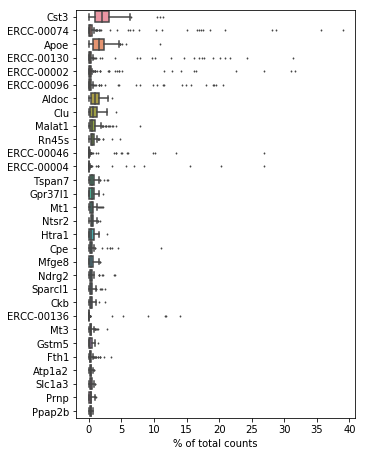

In [4]:
# general look at the highest expressed genes
sc.pl.highest_expr_genes(adata_w)

In [5]:
# detect the ERCC sequences. Save as observation
adata_w.var["ERCC"] = [True if gene.startswith("ERCC-") else False for gene in adata_w.var_names]
ERCC_genes = [gene for gene in adata_w.var_names if gene.startswith('ERCC')]
adata_w.obs['percent_ERCC_genes'] = np.sum(adata_w[:, ERCC_genes].X, axis=1)/ np.sum(adata_w.X, axis=1)
# detect mouse mitochondrial genes from www.ensemble.org. Save as observation
mito = set(sc.queries.mitochondrial_genes('mmusculus'))
adata_w.var["mito"] = [True if gene in mito else False for gene in adata_w.var_names]
# additional detection of mitochondrial genes. Add observation of calculated percentage of mitochondrial genes in each cell
mito_genes = [gene for gene in adata_w.var_names if gene.startswith('mt-')]
adata_w.obs['percent_mito_genes'] = np.sum(adata_w[:, mito_genes].X, axis=1)/ np.sum(adata_w.X, axis=1)
# add the total counts per cell as observation
adata_w.obs['n_counts'] = np.sum(adata_w.X, axis=1)

In [6]:
#calculate the general metrics and the metrics of ERCC and mitochondrial genes
sc.pp.calculate_qc_metrics(adata_w,qc_vars= ['ERCC', 'mito'], inplace=True)
#qc_vars= ['ERCC', 'mito']

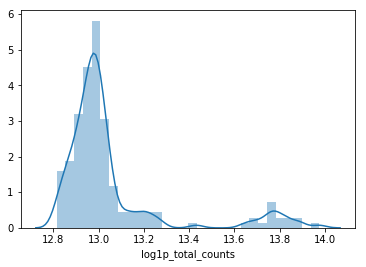

In [7]:
# plot the distribution of total counts in the adata_w object
sns.distplot(adata_w.obs['log1p_total_counts'])
f_count = adata_w.obs_vector('log1p_total_counts') > 11 # all cells having high logaritmized number of reads included

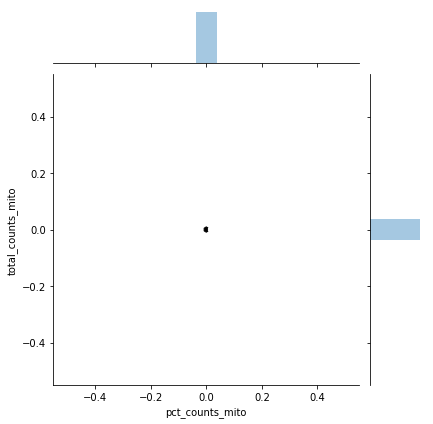

In [8]:
# plot the percentage of number of counts that are mitochondrial and total counts of mitochondrial genes. Mitochondrial genes not detected
sns.jointplot('pct_counts_mito', 'total_counts_mito', data=adata_w.obs, kind="hex")

C:\Users\hanwe868\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\hanwe868\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


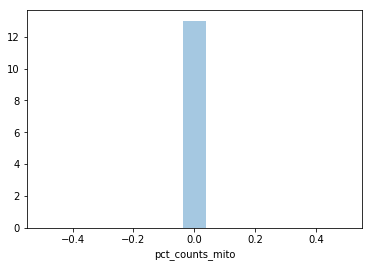

In [9]:
# plot the percentage of mitochondrial genes expressed. No mitochondrial can be detected.
sns.distplot(adata_w.obs['pct_counts_mito'])
m_count = adata_w.obs_vector('pct_counts_mito') < 0.1

... storing 'Animal' as categorical
... storing 'Experiment' as categorical
... storing 'Tissue' as categorical


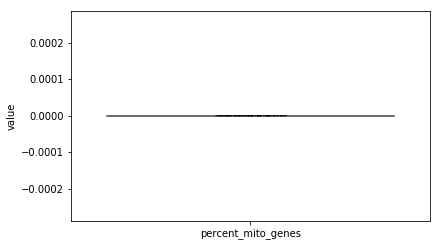

In [10]:
# plot the additional detection of mitochondrial genes in the AnnData object. Mitochondrial genes cannot be detected
sc.pl.violin(adata_w, 'percent_mito_genes')

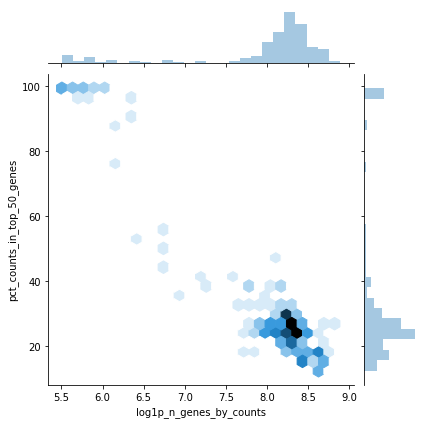

In [11]:
# plot the logaritmized number of genes by counts and the percentage of counts that express the top 50 most expressed genes
sns.jointplot('log1p_n_genes_by_counts', 'pct_counts_in_top_50_genes', data=adata_w.obs, kind="hex")
f_dist = adata_w.obs_vector('pct_counts_in_top_50_genes') < 80 # filter cells with distributed gene counts
f_capt = adata_w.obs_vector('log1p_n_genes_by_counts') > 6.0 # filter cells with broad gene capture

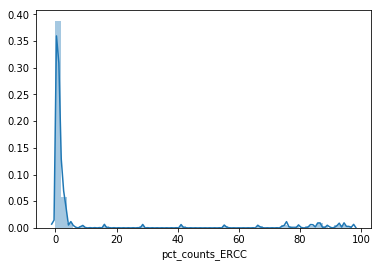

In [12]:
# plot the percentage of counts that are ERCC sequences
sns.distplot(adata_w.obs["pct_counts_ERCC"])
f_ercc = adata_w.obs_vector("pct_counts_ERCC") < 10 # cells with less than 10% ERCC counts included

From the 178 sequenced cells, 151 passed the inclusion criterions and are used for analysis

In [13]:
# filter cells based on inclusion criteria
#f_count, f_dist, f_capt, f_ercc
f1 = np.logical_and(f_count, f_dist, m_count)
f2 = np.logical_and(f_capt, f_ercc)
f = np.logical_and(f1,f2)
print(adata_w.shape)
adata_w = adata_w[f]


# only include genes that are detected in more than 3 neurons
sc.pp.filter_genes(adata_w, min_cells=3)
print(adata_w.shape)

Trying to set attribute `.var` of view, making a copy.


(178, 24582)
(158, 18430)


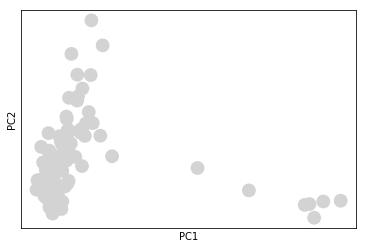

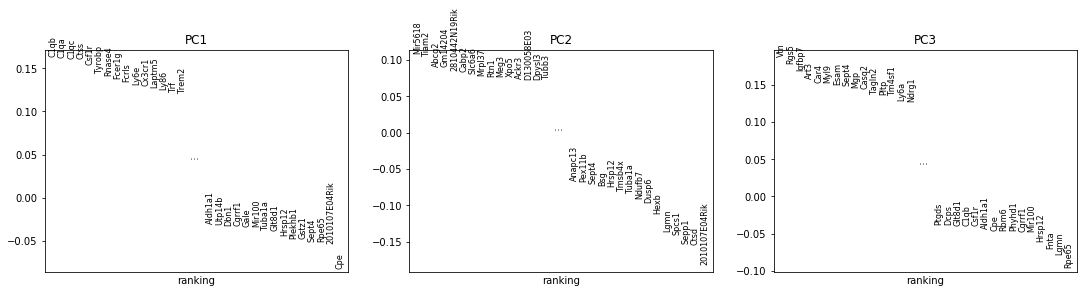

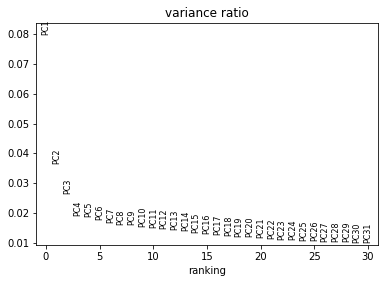

In [14]:
# normalize the number of reads per cell to the median number of reads
sc.pp.normalize_per_cell(adata_w, counts_per_cell_after= adata_w.obs['n_counts'].median())

# logaritmize data
sc.pp.log1p(adata_w)

# detect the most highest variable genes
sc.pp.highly_variable_genes(adata_w, n_top_genes=1000, inplace=True)

# reduce dimensions of data using the highest variable genes
sc.pp.pca(adata_w, use_highly_variable=True)
sc.pl.pca_overview(adata_w)

## Clustering and visualization of the Vmat2-Cre population
Here we use the Leiden method (Traag et al., 2019 , [3]) to cluster the data and Uniform Manifold Approximation and Projection (UMAP) for visualization.

To detect if there are any genes that are significantly expressed by the Leiden defined clusters, we look at the top differentially expressed (DE) genes. In this initial clustering, 8 clusters were detected. However, the only cluster (cluster '7' in UMAP) is the only cluster to have significant DE expression (adjusted p-value < 0.05), where these DE genes include markers for glial cells (http://mousebrain.org) and therefore, the cells belonging to this cluster were excluded. 
From here, the data dimension reduction, topology of the data is and new clusters of the Vmat2-Cre population are recomputed. 

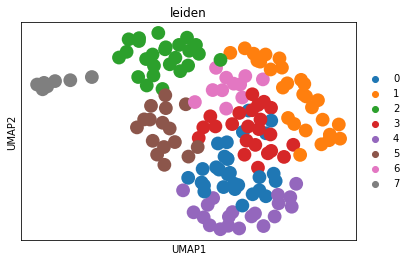

In [15]:
# compute neighborhood graph and visualize with UMAP
sc.pp.neighbors(adata_w, n_neighbors=10, n_pcs=9)
sc.tl.umap(adata_w)
sc.tl.leiden(adata_w, resolution=1)
sc.pl.umap(adata_w, color = 'leiden')

In [16]:
# detect the top DE genes for each Leiden cluster
sc.tl.rank_genes_groups(adata_w, groupby="leiden", n_genes=30)

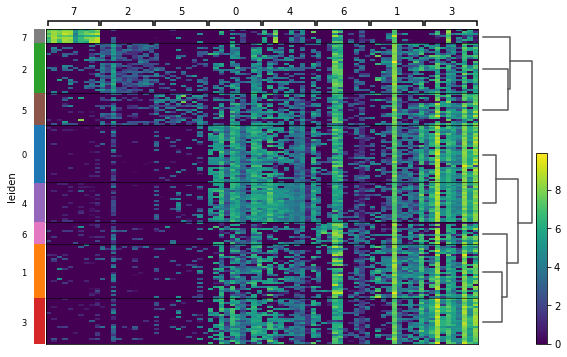

In [17]:
# compute the hierarchial clustering based on Leiden groups and plot the expression of top DE in individual Vmat2-Cre neurons 
sc.tl.dendrogram(adata_w, groupby="leiden")
sc.pl.rank_genes_groups_heatmap(adata_w, n_genes=10)

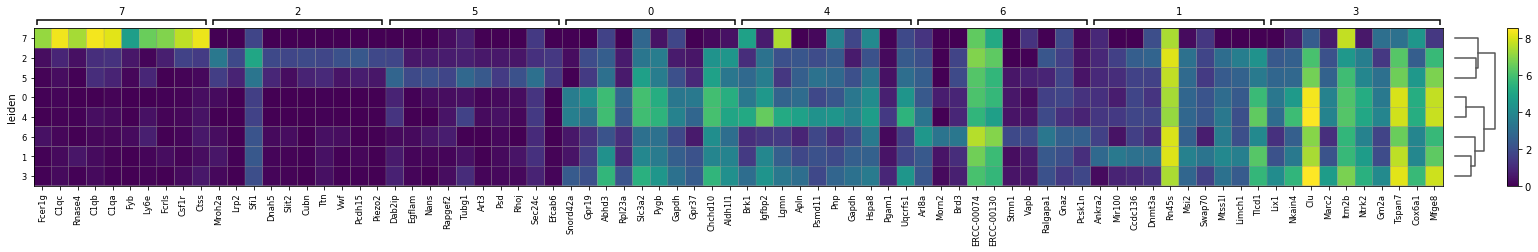

In [19]:
# visualize the mean expression of the top DE in the different Leiden clusters
sc.pl.rank_genes_groups_matrixplot(adata_w, groupby="leiden", n_genes=10)

#fcer1g, C1qb, Ctss are expressed by microglia (linnarson mousebrain atlas)

The detection of DE genes in each cluster shows that only cluster 7 has significant expression (Benjmini-Hochberg adjusted p-value < 0.05). These top DE genes include glial markers (www.linnarssonlab.org)

In [20]:
result = adata_w.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame({group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'scores', 'pvals_adj']}).head(40)

,0_n,0_s,0_p,1_n,1_s,1_p,2_n,2_s,2_p,3_n,...,4_p,5_n,5_s,5_p,6_n,6_s,6_p,7_n,7_s,7_p
0,Snord42a,3.837217,0.74408,Ankra2,3.350881,0.917061,Mroh2a,9.275545,7.738191e-08,Lix1,...,0.579273,Dab2ip,3.569708,0.994616,Arl8a,3.082507,0.891974,Fcer1g,25.418564,1.703568e-07
1,Gpr19,3.814442,0.74408,Mir100,3.285786,0.917061,Lrp2,7.385275,9.053317e-05,Nkain4,...,0.579273,Egflam,3.291088,0.994616,Morn2,2.953545,0.891974,C1qc,23.709831,8.251086e-05
2,Abhd3,3.725592,0.74408,Ccdc136,3.105054,0.917061,Sfi1,7.239398,4.999612e-05,Clu,...,0.579273,Nans,3.279719,0.994616,Brd3,2.897295,0.891974,Rnase4,19.232559,7.192113e-06
3,Rpl23a,3.667274,0.74408,Dnmt3a,3.085383,0.917061,Dnah5,7.184771,8.594140e-05,Marc2,...,0.579273,Rapgef2,3.190447,0.994616,ERCC-00074,2.750598,0.891974,C1qb,17.878868,8.251086e-05
4,Slc3a2,3.610698,0.74408,Rn45s,3.029415,0.917061,Slit2,6.595925,4.678415e-04,Itm2b,...,0.579273,Tubg1,3.076004,0.994616,ERCC-00130,2.276344,0.891974,C1qa,17.687565,9.695950e-05
5,Pygb,3.484342,0.74408,Msi2,3.004234,0.917061,Cubn,6.546286,6.200987e-04,Ntrk2,...,0.579273,Art3,3.054521,0.994616,Stmn1,2.151803,0.891974,Fyb,17.323542,7.192113e-06
6,Gapdh,3.430902,0.74408,Swap70,2.647323,0.917061,Ttn,6.530723,1.708452e-04,Gm2a,...,0.579273,Psd,2.929863,0.994616,Vapb,2.145236,0.891974,Ly6e,15.053866,5.772457e-04
7,Gpr37,3.426074,0.74408,Mtss1l,2.592134,0.917061,Vwf,6.513513,6.461246e-04,Tspan7,...,0.579273,Rhoj,2.911966,0.994616,Ralgapa1,2.065975,0.891974,Fcrls,14.735673,2.771694e-05
8,Chchd10,3.417236,0.74408,Limch1,2.577426,0.917061,Pcdh15,6.438953,6.461246e-04,Cox6a1,...,0.579273,Sec24c,2.897998,0.994616,Gnaz,2.050374,0.891974,Csf1r,14.452173,2.746265e-05
9,Aldh1l1,3.378709,0.74408,Tlcd1,2.567490,0.917061,Piezo2,6.125011,1.734057e-03,Mfge8,...,0.579273,Efcab6,2.881099,0.994616,Pcsk1n,2.046624,0.891974,Ctss,13.783426,3.146148e-05


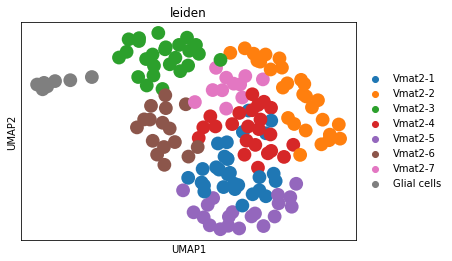

In [21]:
#reassign and plot the cluster names and save file
new_cluster_names = [
    'Vmat2-1', 'Vmat2-2',
    'Vmat2-3', 'Vmat2-4',
    'Vmat2-5', 'Vmat2-6',
    'Vmat2-7','Glial cells']
adata_w.rename_categories('leiden', new_cluster_names)
sc.pl.umap(adata_w, color="leiden", save= 'Vmat2_umap_leiden_unprocc.pdf')

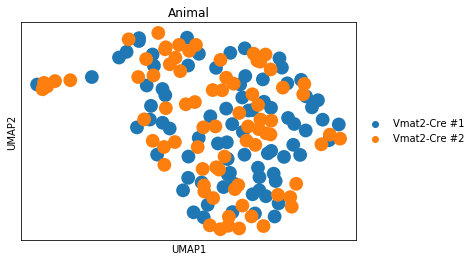

In [22]:
#reassign and plot the animal names and save file
new_cluster_names_animals = [
    'Vmat2-Cre #1', 'Vmat2-Cre #2']
adata_w.rename_categories('Animal', new_cluster_names_animals)
sc.pl.umap(adata_w, color="Animal", save= 'Vmat2_umap_animals_unprocc.pdf')

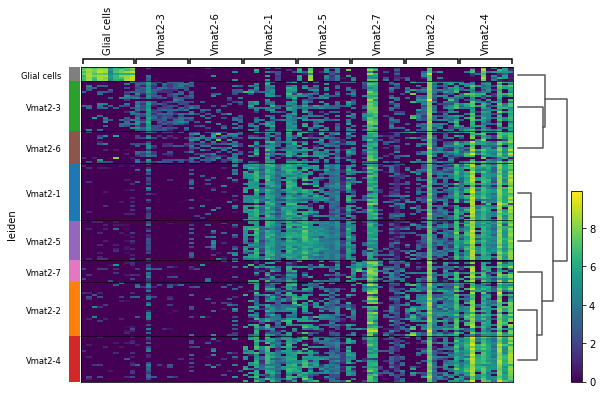

In [23]:
# save heatmap image with new cluster names
sc.pl.rank_genes_groups_heatmap(adata_w, n_genes=10, save = 'Vmat2_heatmap_unprocc.pdf')

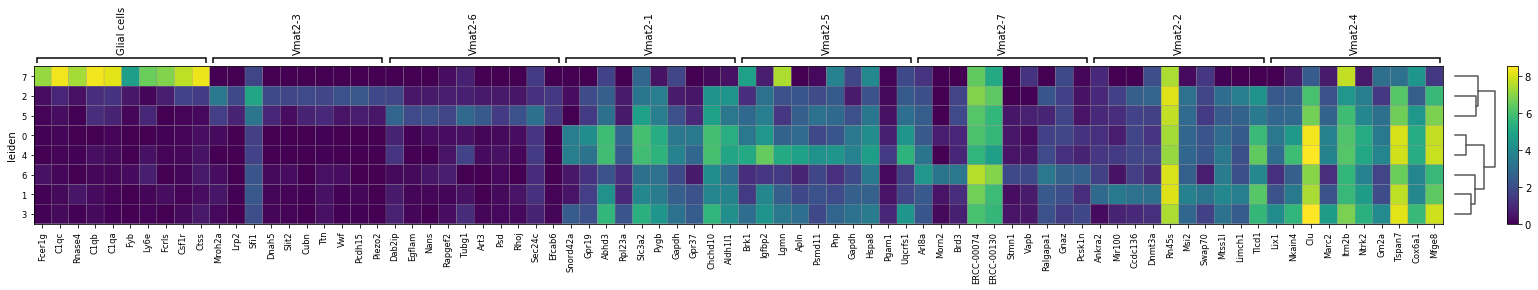

In [24]:
# save the matrixplot with new cluster names
sc.pl.rank_genes_groups_matrixplot(adata_w, groupby="leiden", n_genes=10, save = 'Vmat2_matrix_unprocc.pdf')

Here we are excluding the Vmat2-Cre cells that belonged to the glial cluster, resulting in 151 cells used for analysis

In [25]:
not_microglia = [False if group == "Glial cells" else True for group in adata_w.obs["leiden"]]
adata_w = adata_w[not_microglia]
adata_w

View of AnnData object with n_obs × n_vars = 151 × 18430 
    obs: 'Animal', 'Experiment', 'Tissue', 'percent_ERCC_genes', 'percent_mito_genes', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_ERCC', 'log1p_total_counts_ERCC', 'pct_counts_ERCC', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'leiden'
    var: 'ERCC', 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'rank_genes_groups', 'dendrogram_leiden', 'Animal_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

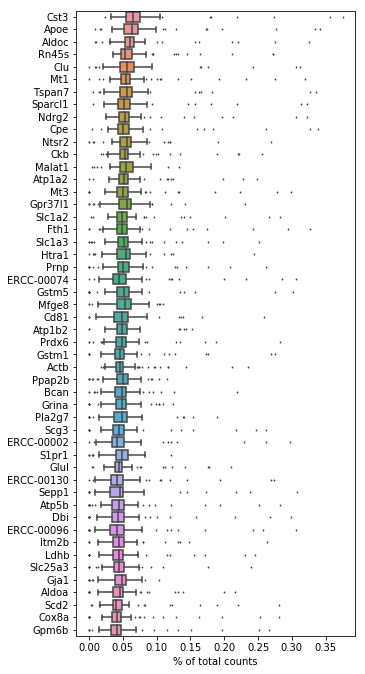

In [26]:
# general check of which genes that are most prevalent in our 'true' Vmat2-Cre population
sc.pl.highest_expr_genes(adata_w, n_top = 50, save ='Vmat2_highest_exp_genes.pdf')

Re-performing the data dimensional reduction and visualizations

Trying to set attribute `.var` of view, making a copy.


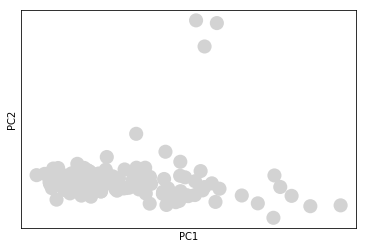

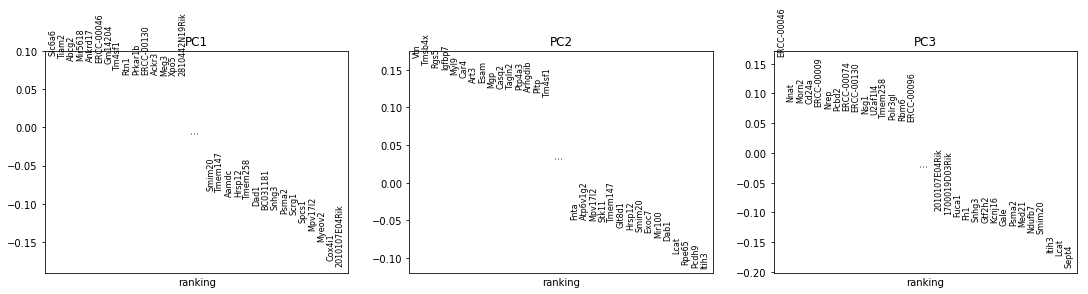

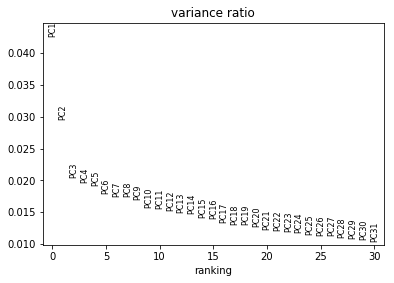

In [27]:
sc.pp.highly_variable_genes(adata_w, n_top_genes=1000, inplace=True)
sc.pp.pca(adata_w, use_highly_variable=True)
sc.pl.pca_overview(adata_w)

8 new clusters can be detected using the Leiden method. Again, only one of the clusters display significant top DE expression (cluster '1'/'Vmat2-2')

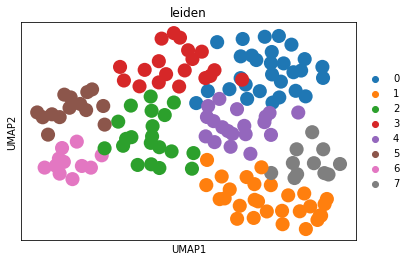

In [28]:
sc.pp.neighbors(adata_w, n_neighbors=10, n_pcs=9)
sc.tl.umap(adata_w)

sc.tl.leiden(adata_w, resolution=1)
sc.pl.umap(adata_w, color= 'leiden')

adata_w_red = adata_w

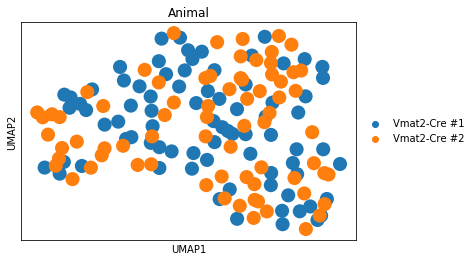

In [29]:
# display the animal origin of the cells and save file
sc.pl.umap(adata_w, color= 'Animal', save ='Vmat2_UMAP_procc_animals.pdf')

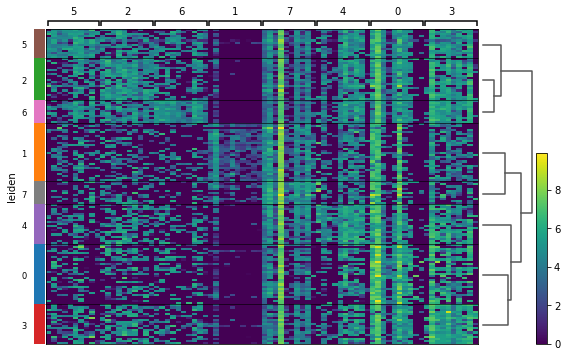

In [30]:
# find DE genes for the individual Leiden clusters
sc.tl.rank_genes_groups(adata_w, groupby="leiden", n_genes=30)
sc.tl.dendrogram(adata_w, groupby="leiden")

# display the expression of the top DE in the individual Vmat2-Cre neurons according to Leiden cluster
sc.pl.rank_genes_groups_heatmap(adata_w, n_genes=10)

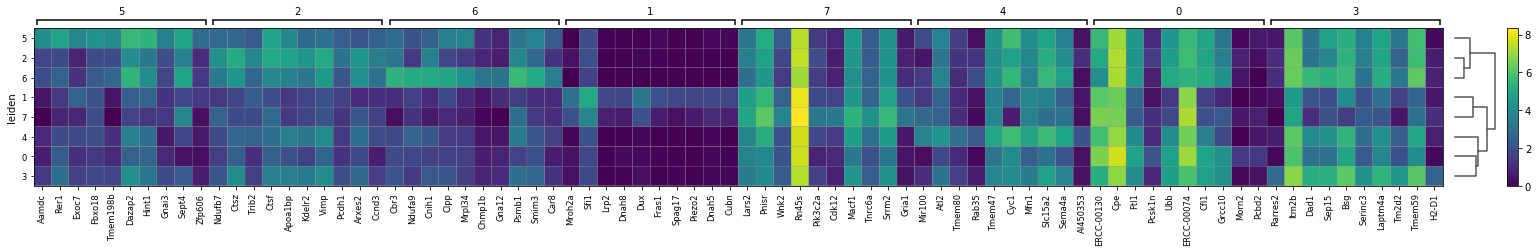

In [31]:
# display the mean expression of the top DE genes in the Leiden clusters
sc.pl.rank_genes_groups_matrixplot(adata_w, groupby="leiden", n_genes=10)

In [32]:
result = adata_w.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame({group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'scores', 'pvals_adj']}).head(40)

,0_n,0_s,0_p,1_n,1_s,1_p,2_n,2_s,2_p,3_n,...,4_p,5_n,5_s,5_p,6_n,6_s,6_p,7_n,7_s,7_p
0,ERCC-00130,3.422177,0.714774,Mroh2a,8.359562,6.956293e-07,Ndufb7,3.298530,0.883577,Rarres2,...,0.903025,Aamdc,4.322733,0.917739,Cbr3,4.843102,0.876992,Lars2,3.527689,0.942478
1,Cpe,3.182888,0.714774,Sfi1,7.951914,2.551877e-06,Ctsz,3.298182,0.883577,Itm2b,...,0.903025,Rer1,4.223228,0.917739,Ndufa9,4.540457,0.876992,Pnisr,3.301408,0.942478
2,Ftl1,3.020025,0.714774,Lrp2,7.307609,6.123624e-05,Trib2,3.267533,0.883577,Dad1,...,0.903025,Exoc7,3.936109,0.917739,Cnih1,4.153971,0.876992,Wnk2,3.128484,0.942478
3,Pcsk1n,2.741149,0.714774,Dnah8,7.297258,6.123624e-05,Ctsf,3.173201,0.883577,Sep15,...,0.903025,Fbxo18,3.639461,0.917739,Clpp,4.101625,0.876992,Rn45s,3.024423,0.942478
4,Ubb,2.694131,0.714774,Dux,7.274073,4.312718e-05,Apoa1bp,3.123054,0.883577,Bsg,...,0.903025,Tmem198b,3.621147,0.917739,Mrpl34,3.824418,0.876992,Pik3c2a,3.005992,0.942478
5,ERCC-00074,2.542870,0.714774,Fras1,7.025918,1.400763e-04,Kdelr2,3.120881,0.883577,Serinc3,...,0.903025,Dazap2,3.486186,0.917739,Chmp1b,3.781712,0.876992,Cdk12,2.996444,0.942478
6,Cfl1,2.498789,0.714774,Spag17,6.698794,2.979430e-04,Vimp,3.084744,0.883577,Laptm4a,...,0.903025,Hint1,3.432804,0.917739,Gna12,3.775295,0.876992,Macf1,2.988582,0.942478
7,Grcc10,2.247355,0.714774,Piezo2,6.543379,3.081891e-04,Pcdh1,3.054100,0.883577,Tm2d2,...,0.903025,Gnai3,3.275112,0.917739,Psmb1,3.773856,0.876992,Tnrc6a,2.987689,0.942478
8,Morn2,2.202132,0.714774,Dnah5,6.447430,2.065041e-04,Arxes2,3.036444,0.883577,Tmem59,...,0.903025,Sept4,3.238672,0.917739,Smim3,3.713049,0.876992,Srrm2,2.897802,0.942478
9,Pcbd2,2.171006,0.714774,Cubn,6.383683,2.979430e-04,Ccnd3,2.988550,0.883577,H2-D1,...,0.903025,Zfp606,3.122823,0.917739,Car8,3.691662,0.876992,Gria1,2.868410,0.942478


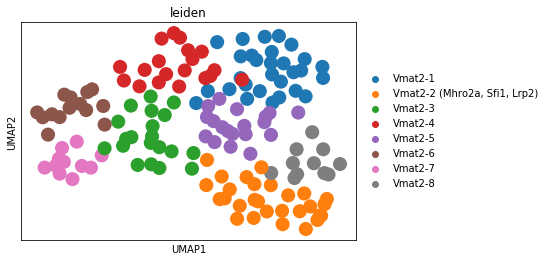

In [33]:
#reassign the cluster names and save UMAP file
new_cluster_names_procc = [
    'Vmat2-1', 'Vmat2-2 (Mhro2a, Sfi1, Lrp2)',
    'Vmat2-3', 'Vmat2-4',
    'Vmat2-5', 'Vmat2-6',
    'Vmat2-7', 'Vmat2-8']

adata_w.rename_categories('leiden', new_cluster_names_procc)
sc.pl.umap(adata_w, color= 'leiden', save = 'Vmat2_UMAP_procc_leiden.pdf' )

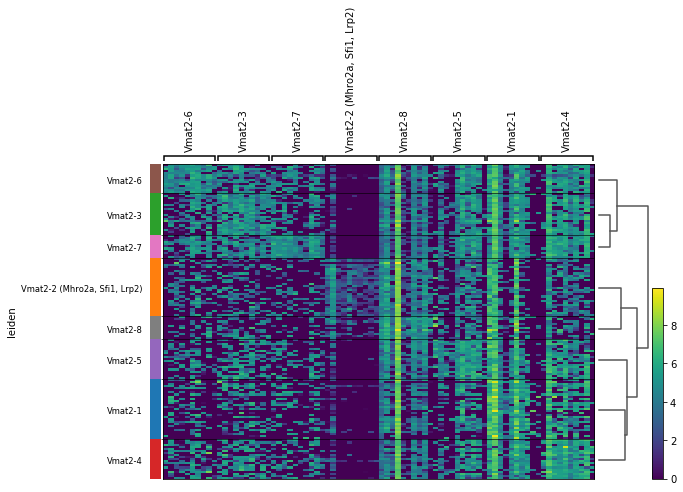

In [34]:
# save the heatmap with new cluster names
sc.pl.rank_genes_groups_heatmap(adata_w, n_genes=10, save = 'Vmat2_heatmap_procc_leiden.pdf')

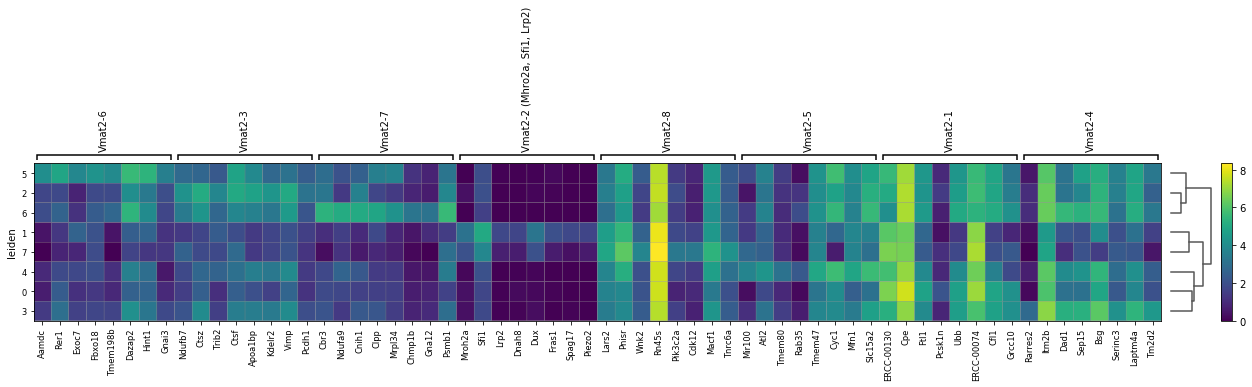

In [35]:
# save the matrixplot with new cluster names
sc.pl.rank_genes_groups_matrixplot(adata_w, groupby="leiden", n_genes=8, save = 'Vmat2_matrix_procc.pdf')

## Specific gene expression analysis
Since the molecular pattern of the Vmat2-Cre population indicates that it is a homogenous population, the expression analysis of target genes is performed as a bulk analysis. Here we wanted to examine if the Vmat2 population expresses genes involved in serotonin synthesis, cortical layer markers (Zeisel et al., 2018 [1]; Harris et al., 2014 [5]) and if we could verify the excitatory properties seen during electrophysiological recordings. 

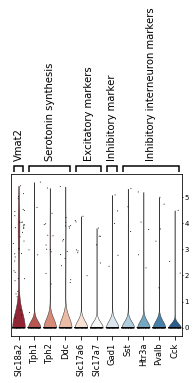

In [36]:
# create labels and tuple for positioning of labels for the violin plot
group_labels_1 = ['Vmat2', 'Serotonin synthesis', 'Excitatory markers', 'Inhibitory marker', 'Inhibitory interneuron markers']
group_position_1 = [(0,0), (1,3), (4,5), (6,6), (7,10)]
# create a list of the target genes
marker_genes_1 = ['Slc18a2', 'Tph1', 'Tph2', 'Ddc', 'Slc17a6', 'Slc17a7', 'Gad1','Sst', 'Htr3a','Pvalb', 'Cck']

# visualize the expression with violin plot. Save the file 
sc.pl.stacked_violin(adata_w, var_names = marker_genes_1, var_group_labels = group_labels_1, var_group_positions = group_position_1,
                     stripplot = True, jitter = 0.4, palette = "RdBu", save = 'Vmat2_violin_marker_genes_exc_inhib.pdf')

# Inhibitory markers Viaat (Slc32a1) and inhibitory interneuron marker VIP and Npy not detected

In [37]:
[name for name in adata_w.var_names if name.startswith('Tbr')]

['Tbr1', 'Tbrg1', 'Tbrg4', 'Tbrg3']

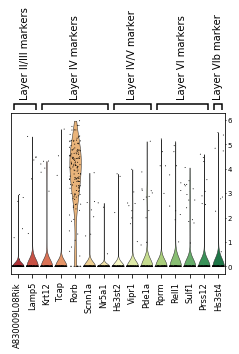

In [38]:
# create labels and tuple for positioning of labels for the violin plot
group_labels_2 = ['Layer II/III markers', 'Layer IV markers', 'Layer IV/V marker', 'Layer VI markers',
                'Layer VIb marker']
group_position_2 = [(0,1), (2,6), (7,9), (10,13), (14,14)]
# create a list of the target genes
marker_genes_2 = ['A830009L08Rik', 'Lamp5','Krt12', 'Tcap', 
                'Rorb', 'Scnn1a', 'Nr5a1','Hs3st2', 'Vipr1', 'Pde1a', 'Rprm', 'Rell1', 'Sulf1', 'Prss12', 'Hs3st4']

# visualize the expression with violin plot. Save the file 
sc.pl.stacked_violin(adata_w, var_names = marker_genes_2, var_group_labels = group_labels_2, var_group_positions = group_position_2,
                     stripplot = True, jitter = 0.4, palette = "RdYlGn", save = 'Vmat2_violin_new_marker_genes_layer.pdf')

# layer 4 marker Tbr2 not found in dataset

Here we are calculating the prevalence of the Vmat2-Cre neurons that express the target genes (gene considered expressed if log1p => 0.25, see function in top of notebook). Layer 4 marker Rorb is mostly prevalent in the Vmat2-Cre population, whereas the other marker genes are lowly detected. From plots and prevalence calculations, we cannot verify that the Vmat2-Cre population is excitatory since the expression of excitatory and inhibitory markers are similar

In [41]:
# calculate the prevalence of the target genes in the Vmat2 population
percentage_exp(adata_w, (marker_genes_1 + marker_genes_2))

C:\Users\hanwe868\AppData\Local\Continuum\anaconda3\lib\site-packages\anndata\core\anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


[('Rorb', 92.71523178807946),
 ('Slc18a2', 25.165562913907287),
 ('Ddc', 9.933774834437086),
 ('Sulf1', 9.271523178807946),
 ('Pde1a', 8.609271523178808),
 ('Tph2', 7.9470198675496695),
 ('Rell1', 7.9470198675496695),
 ('Vipr1', 5.960264900662252),
 ('Prss12', 5.298013245033113),
 ('Hs3st4', 5.298013245033113),
 ('Slc17a6', 4.635761589403973),
 ('Scnn1a', 4.635761589403973),
 ('A830009L08Rik', 3.9735099337748347),
 ('Lamp5', 3.9735099337748347),
 ('Krt12', 3.9735099337748347),
 ('Tph1', 3.3112582781456954),
 ('Slc17a7', 3.3112582781456954),
 ('Gad1', 3.3112582781456954),
 ('Htr3a', 3.3112582781456954),
 ('Pvalb', 3.3112582781456954),
 ('Rprm', 3.3112582781456954),
 ('Sst', 1.9867549668874174),
 ('Cck', 1.9867549668874174),
 ('Tcap', 1.9867549668874174),
 ('Nr5a1', 1.9867549668874174),
 ('Hs3st2', 1.9867549668874174)]

In [42]:
number_exp(adata_w, (marker_genes_1 + marker_genes_2))

C:\Users\hanwe868\AppData\Local\Continuum\anaconda3\lib\site-packages\anndata\core\anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


[('Rorb', 140.0),
 ('Slc18a2', 38.0),
 ('Ddc', 14.999999999999998),
 ('Sulf1', 14.0),
 ('Pde1a', 13.0),
 ('Tph2', 12.0),
 ('Rell1', 12.0),
 ('Vipr1', 9.0),
 ('Prss12', 8.0),
 ('Hs3st4', 8.0),
 ('Slc17a6', 7.0),
 ('Scnn1a', 7.0),
 ('A830009L08Rik', 6.0),
 ('Lamp5', 6.0),
 ('Krt12', 6.0),
 ('Tph1', 5.0),
 ('Slc17a7', 5.0),
 ('Gad1', 5.0),
 ('Htr3a', 5.0),
 ('Pvalb', 5.0),
 ('Rprm', 5.0),
 ('Sst', 3.0),
 ('Cck', 3.0),
 ('Tcap', 3.0),
 ('Nr5a1', 3.0),
 ('Hs3st2', 3.0)]

To examine what kind of input that the Vmat2-Cre population recieves, the 'targets_and families.csv' file was downloaded from Guide to Pharmacology (https://www.guidetopharmacology.org/download.jsp). We are using this file to extract all ligand-gated ion channels (lgics) and GPCRs, respectively, followed by calculation and ranking of the prevalence of these genes in the Vmat2-Cre population (for function, see top of notebook). 

In [45]:
# read the 'targets_and_families.csv' file from Guide to Pharmacology
targets_families = pd.read_csv('targets_and_families.csv')
targets_families.head()

,Type,Family id,Family name,Target id,Target name,Subunits,Target systematic name,Target abbreviated name,synonyms,HGNC id,...,Rat SwissProt,Rat Entrez Gene,MGI id,MGI symbol,MGI name,Mouse genetic localisation,Mouse nucleotide RefSeq,Mouse protein RefSeq,Mouse SwissProt,Mouse Entrez Gene
0,gpcr,1,5-Hydroxytryptamine receptors,1,5-HT<sub>1A</sub> receptor,NaN,NaN,NaN,ADRBRL1|5-HT1A|ADRB2RL1|serotonin receptor 1A|...,5286,...,P19327,24473,MGI:96273,Htr1a,5-hydroxytryptamine (serotonin) receptor 1A,13 D2.1,NM_008308,NP_032334,Q64264,15550
1,gpcr,1,5-Hydroxytryptamine receptors,2,5-HT<sub>1B</sub> receptor,NaN,NaN,NaN,5-HT1B|5-HT1DB|HTR1D2|5-HT1B serotonin recepto...,5287,...,P28564,25075,MGI:96274,Htr1b,5-hydroxytryptamine (serotonin) receptor 1B,9 E1,NM_010482,NP_034612,P28334,15551
2,gpcr,1,5-Hydroxytryptamine receptors,3,5-HT<sub>1D</sub> receptor,NaN,NaN,NaN,5-HT<sub>1D&alpha;</sub>|HTRL|5-HT1D|HT1DA|ser...,5289,...,P28565,25323,MGI:96276,Htr1d,5-hydroxytryptamine (serotonin) receptor 1D,4 D3,NM_008309,NP_032335,Q61224,15552
3,gpcr,1,5-Hydroxytryptamine receptors,4,5-ht<sub>1e</sub> receptor,NaN,NaN,NaN,5-HT<sub>1E</sub><sub>&alpha;</sub>|5-HT1E|5-h...,5291,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,gpcr,1,5-Hydroxytryptamine receptors,5,5-HT<sub>1F</sub> receptor,NaN,NaN,NaN,5-HT<sub>1E&beta;</sub>|5-HT<sub>6</sub>|5-HT1...,5292,...,P30940,60448,MGI:99842,Htr1f,5-hydroxytryptamine (serotonin) receptor 1F,16 C1.3,NM_008310,NP_032336,Q02284,15557


In [46]:
#lists of all genes from target receptor type
gpcr_list = rec_type_list(targets_families, 'gpcr')
lgic_list = rec_type_list(targets_families, 'lgic')

In [48]:
#calculate the prevalence of lgic genes in Vmat2-Cre population 
percent_lgic = pd.DataFrame(percentage_exp(adata_w, lgic_list), columns = ['gene_name', 'percent'])
print(percent_lgic[:51])
#save a dataframe of the gene names of the top 40 lgic genes. Use for expression visualization
top_lgig = list(percent_lgic['gene_name'][:41])

C:\Users\hanwe868\AppData\Local\Continuum\anaconda3\lib\site-packages\anndata\core\anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


   gene_name    percent
0      Gria2  93.377483
1     Grin2c  93.377483
2     Gabrb1  86.092715
3      Itpr2  80.794702
4     Gabrg1  66.887417
5      Grik5  54.304636
6       Glrb  51.655629
7     Gabra2  42.384106
8     Grin2b  38.410596
9     Gabra4  35.099338
10     Gria1  32.450331
11     P2rx7  27.152318
12     P2rx4  26.490066
13     Grid2  26.490066
14     Itpr1  25.165563
15     Asic2  24.503311
16     Grid1  24.503311
17    Grin3a  19.867550
18     Grik3  12.582781
19   Grid2ip  11.920530
20    Gabra5  11.258278
21     Itpr3  11.258278
22     Grik1  10.596026
23     Grik2   9.933775
24     Asic1   9.933775
25     Glra1   9.271523
26     Gabre   8.609272
27    Gabrb2   8.609272
28     Gria3   7.947020
29     Gabrq   7.947020
30    Gabrr2   7.284768
31    Gabrg3   7.284768
32     Grik4   7.284768
33    Gabra1   7.284768
34    Grin2a   7.284768
35     Grin1   6.622517
36    Chrnb2   6.622517
37     Htr3b   6.622517
38    Grin3b   6.622517
39     P2rx1   6.622517
40    Chrna2   6

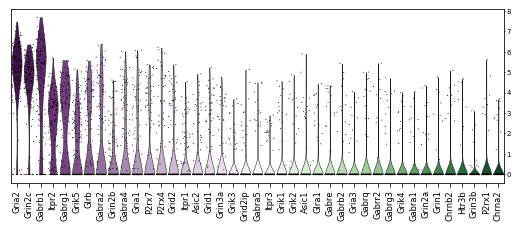

In [49]:
# visualize the expression of the top prevalent lgics
sc.pl.stacked_violin(adata_w, var_names= top_lgig, palette= 'PRGn',  stripplot= True, jitter = 0.4, save = 'Vmat2_violin_lgic_input.pdf')

In [50]:
#calculate the prevalence of GPCR genes in the Vmat2-Cre population 
percent_gpcr = pd.DataFrame(percentage_exp(adata_w, gpcr_list), columns = ['gene_name', 'percent'])
print(percent_gpcr[:51])
#save a dataframe of the gene names of the top 40 GPCR genes. Use for expression visualization
top_gpcr = list(percent_gpcr['gene_name'][:41])

C:\Users\hanwe868\AppData\Local\Continuum\anaconda3\lib\site-packages\anndata\core\anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


    gene_name    percent
0       Ntsr2  98.675497
1     Gpr37l1  98.013245
2       S1pr1  98.013245
3        Grm3  93.377483
4      Gabbr1  87.417219
5       Ednrb  84.768212
6        Smox  80.132450
7        Fzd2  79.470199
8   Adcyap1r1  76.821192
9        Rhoa  73.509934
10     Gprc5b  69.536424
11       Lgr4  68.211921
12     Gpr146  68.211921
13       Rhob  67.549669
14     Celsr2  63.576159
15      Rhot1  60.927152
16     Gpr162  56.953642
17       Lgr6  56.291391
18       Rhoq  54.966887
19      Gpr19  52.317881
20      Gpr37  51.655629
21       Rhou  49.668874
22       Hrh1  47.682119
23     Gpr107  46.357616
24       Fzd1  46.357616
25    Rhobtb2  45.033113
26    Adora2b  41.059603
27     Celsr1  40.397351
28       Fzd9  36.423841
29     Adora1  35.761589
30     Gabbr2  35.761589
31     Gpr108  33.112583
32      Tpra1  32.450331
33     Gpr155  31.788079
34    Rhobtb3  31.125828
35     Gpr137  31.125828
36      Lpar6  29.139073
37       Rhoc  28.476821
38      Rhot2  27.152318


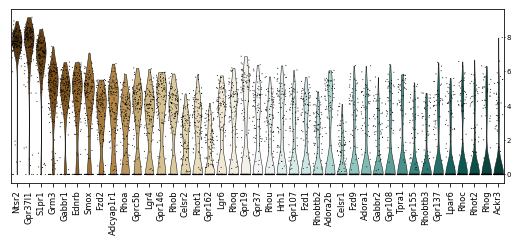

In [51]:
# visualize the expression of the top prevalent GPCRs
sc.pl.stacked_violin(adata_w, var_names= top_gpcr, palette= 'BrBG',  stripplot= True, jitter = 0.4, save = 'Vmat2_violin_gpcr_input.pdf')

# Prediction of location and cell types of Vmat2-Cre neurons 
Dataset from Zeisel et al (2018, [1]). The single-cell data has been obtained through the 10X Genomics method. We are initially processing the dataset in the same manner as for the Vmat2-Cre dataset, except for preproccessing the data according to ERCC since the 10X Genomics method does not include ERCCs. Thereafter, we are merging and aligning the two datasets based on MNN to see if the Vmat2-Cre population molecularily map to cortical layer 4. 

In [42]:
#read the Zeisel et al dataset
adata_z_proj = sc.read_loom('l6_r3_telencephalon_projecting_neurons.loom', sparse = False)
adata_z_proj

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 28858 × 27998 
    obs: 'Age', 'AnalysisPool', 'AnalysisProject', 'Bucket', 'CellConc', 'Cell_Conc', 'ChipID', 'Class', 'ClassProbability_Astrocyte', 'ClassProbability_Astrocyte,Immune', 'ClassProbability_Astrocyte,Neurons', 'ClassProbability_Astrocyte,Oligos', 'ClassProbability_Astrocyte,Vascular', 'ClassProbability_Bergmann-glia', 'ClassProbability_Blood', 'ClassProbability_Blood,Vascular', 'ClassProbability_Enteric-glia', 'ClassProbability_Enteric-glia,Cycling', 'ClassProbability_Ependymal', 'ClassProbability_Ex-Neurons', 'ClassProbability_Ex-Vascular', 'ClassProbability_Immune', 'ClassProbability_Immune,Neurons', 'ClassProbability_Immune,Oligos', 'ClassProbability_Neurons', 'ClassProbability_Neurons,Cycling', 'ClassProbability_Neurons,Oligos', 'ClassProbability_Neurons,Satellite-glia', 'ClassProbability_Neurons,Vascular', 'ClassProbability_OEC', 'ClassProbability_Oligos', 'ClassProbability_Oligos,Cycling', 'ClassProbability_Oligos,Vascular', 'Cl

In [43]:
#make the observations and gene names unique
adata_z_proj.obs_names_make_unique()
adata_z_proj.var_names_make_unique()

In [44]:
print(calc_celltype_observation(adata_z_proj, 'Probable_location'))

                                                    number_cells
obs_name                                                        
Anterior olfactory nucleus and ventral striatum               89
Anterior olfactory nucleus, deep layer                       657
Basolateral amygdala                                         958
CA1                                                         2037
CA1 (posterior),subiculum,entorhinal                         104
CA3                                                          484
Cingulate/Retrosplenial area, layer 2                        598
Cingulate/Retrosplenial area, layer 5                        202
Cingulate/Retrosplenial area, layer 6                        402
Cortex pyramidal layer 5, Cingulate/Retrospleni...           664
Cortex pyramidal layer 6                                    2789
Cortex pyramidal layer 6b                                    274
Cortical pyramidal (poor markers)                           1464
Cortical pyramidal layer 

In [45]:
#isolate all the cortical neurons
adata_z_cortex = adata_z_proj[adata_z_proj.obs['Region'] == 'Cortex']
adata_z_cortex

View of AnnData object with n_obs × n_vars = 15216 × 27998 
    obs: 'Age', 'AnalysisPool', 'AnalysisProject', 'Bucket', 'CellConc', 'Cell_Conc', 'ChipID', 'Class', 'ClassProbability_Astrocyte', 'ClassProbability_Astrocyte,Immune', 'ClassProbability_Astrocyte,Neurons', 'ClassProbability_Astrocyte,Oligos', 'ClassProbability_Astrocyte,Vascular', 'ClassProbability_Bergmann-glia', 'ClassProbability_Blood', 'ClassProbability_Blood,Vascular', 'ClassProbability_Enteric-glia', 'ClassProbability_Enteric-glia,Cycling', 'ClassProbability_Ependymal', 'ClassProbability_Ex-Neurons', 'ClassProbability_Ex-Vascular', 'ClassProbability_Immune', 'ClassProbability_Immune,Neurons', 'ClassProbability_Immune,Oligos', 'ClassProbability_Neurons', 'ClassProbability_Neurons,Cycling', 'ClassProbability_Neurons,Oligos', 'ClassProbability_Neurons,Satellite-glia', 'ClassProbability_Neurons,Vascular', 'ClassProbability_OEC', 'ClassProbability_Oligos', 'ClassProbability_Oligos,Cycling', 'ClassProbability_Oligos,Vascul

Here we isolate all neurons that are located in the cortical layers.

In [46]:
# make a list for all the neurons to be included for analysis, i.e. the cortical neurons from the somatosensory area 
cor_pyr = [name for name in adata_z_cortex.obs['Probable_location'] if name.startswith('Cort')]
# make a list of the neurons that are to be excluded from analysis
cor_pyr_exc = [name for name in adata_z_cortex.obs['Probable_location'] if name.startswith(('Cortical pyramidal (poo', 'Cortex pyramidal layer 5, Cingul'))]
cor_pyr_exc

# create bool observation for cortical neurons, create new adata object
adata_z_cortex.obs['pyr_cell'] = adata_z_cortex.obs['Probable_location'].isin(cor_pyr).astype(str)
adata_z_cortex = adata_z_cortex[adata_z_cortex.obs['pyr_cell'] == 'True']
# create bool observation for the neurons that we do not want to include in the analysis, upgrade the zeisel adata object including only the cells we want for analysis
adata_z_cortex.obs['bad_cells'] = adata_z_cortex.obs['Probable_location'].isin(cor_pyr_exc).astype(str)
adata_z = adata_z_cortex[adata_z_cortex.obs['bad_cells'] == 'False']

Trying to set attribute `.obs` of view, making a copy.
Trying to set attribute `.obs` of view, making a copy.


In [47]:
# create observations for basic preprocessing. 
adata_z.var['mito'] = [True if gene in mito else False for gene in adata_z.var_names]
adata_z.var['ERCC'] = [True if gene.startswith('ERCC-') else False for gene in adata_z.var_names] # the 10X method does not include ERCC, but adding observation since function below
adata_z.obs['n_counts'] =  np.sum(adata_z.X, axis = 1)                                            ## did not work with only the 'mito' observation

Trying to set attribute `.var` of view, making a copy.


In [48]:
# calulate the metrics based on prevalence of mito and ERCC
sc.pp.calculate_qc_metrics(adata_z, qc_vars= ['mito', 'ERCC'], inplace=True)

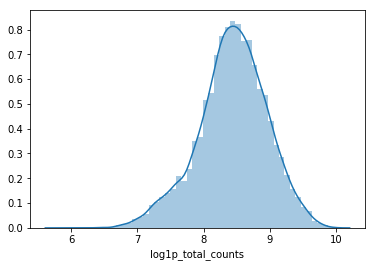

In [49]:
# visualize the logaritmized distribution of total counts. Save observation for all the neurons with higher number
sns.distplot(adata_z.obs['log1p_total_counts'])
f_count = adata_z.obs_vector('log1p_total_counts') > 7

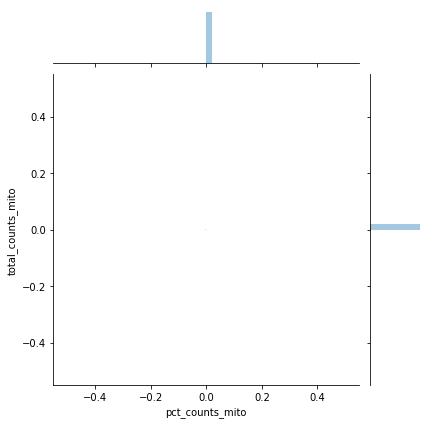

In [50]:
# plot the percentage of number of counts that are mitochondrial and total counts of mitochondrial genes. Mitochondrial genes not detected
sns.jointplot('pct_counts_mito', 'total_counts_mito', data=adata_z.obs, kind="hex")
f_mito = adata_z.obs_vector('pct_counts_mito') < 0.1

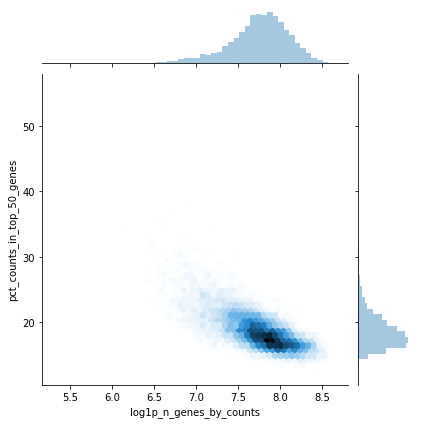

In [51]:
# plot the logaritmized number of genes by counts and the percentage of counts that express the top 50 most expressed genes
sns.jointplot('log1p_n_genes_by_counts', 'pct_counts_in_top_50_genes', data=adata_z.obs, kind="hex")
f_dist = adata_z.obs_vector('pct_counts_in_top_50_genes') < 40 # filter cells with distributed gene counts
f_capt = adata_z.obs_vector('log1p_n_genes_by_counts') > 6.0 # filter cells with broad gene capture

In [52]:
# filter cells that fulfill the criterion 
f3 = np.logical_and(f_count, f_dist)
f4 = np.logical_and(f_capt, f_mito)
f5 = np.logical_and(f3,f4)
print(adata_z.shape)
adata_z = adata_z[f5]
# filter genes that are not detected in more than 3 cells
sc.pp.filter_genes(adata_z, min_cells=3)
print(adata_z.shape)

(9435, 27998)


Trying to set attribute `.var` of view, making a copy.


(9369, 17304)


In [53]:
# normalize the counts per cell to the median count per cell and logaritmize the data
sc.pp.normalize_per_cell(adata_z, counts_per_cell_after=adata_z.obs['n_counts'].median())
sc.pp.log1p(adata_z)

Here, the two datasets are merged based on the expression of all genes to get an estimation of how similar the datasets are and how it may differ after the MNN is performed. As seen in the PCA scatter plot below, the datasets are not aligning well before MNN

In [54]:
# merge the two datasets based on all genes. Genes not expressed in the other dataset will be set as zero
adata_merged = adata_z.concatenate(adata_w, join= 'outer', batch_categories= ['Zeisel', 'Vmat2-Cre'])
adata_merged.X = np.nan_to_num(adata_merged.X)

# make the observation names unique
adata_merged.obs_names_make_unique()
adata_merged.var_names_make_unique()

... storing 'Age' as categorical
... storing 'AnalysisPool' as categorical
... storing 'AnalysisProject' as categorical
... storing 'Animal' as categorical
... storing 'Bucket' as categorical
... storing 'CellConc' as categorical
... storing 'Cell_Conc' as categorical
... storing 'ChipID' as categorical
... storing 'Class' as categorical
... storing 'ClusterName' as categorical
... storing 'Comment' as categorical
... storing 'Comments' as categorical
... storing 'DateCaptured' as categorical
... storing 'Date_Captured' as categorical
... storing 'Description' as categorical
... storing 'Developmental_compartment' as categorical
... storing 'DonorID' as categorical
... storing 'Estimated Number of Cells' as categorical
... storing 'Experiment' as categorical
... storing 'Flowcell' as categorical
... storing 'Fraction Reads in Cells' as categorical
... storing 'Label' as categorical
... storing 'Location_based_on' as categorical
... storing 'Mean Reads per Cell' as categorical
... stori

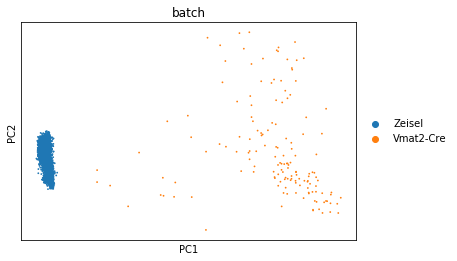

In [55]:
# reduce dimensions of data and visualize
sc.pp.pca(adata_merged)
sc.pl.pca_scatter(adata_merged, color= 'batch', save = 'Vmat2_zeisel_pca_scatter_unprocc.pdf')

#make the observation names unique
adata_merged.obs_names_make_unique()
adata_merged.var_names_make_unique()

## Alignment of the Vmat2-Cre and Zeisel datasets 
To align the datasets, the most highly variable genes are extracted from both datasets and the shared top variable genes are later used for correcting for the batch effects using the MNN method (Haghverdi et al., 2018 [2]). Firstly, we extract the most highly variable genes from both datasets

In [56]:
# extract the top 5000 genes with highest variability from the Zeisel dataset
sc.pp.highly_variable_genes(adata_z, n_top_genes=5000)
# extract the top 5000 genes with highest variability from the Vmat2-Cre dataset
sc.pp.highly_variable_genes(adata_w, n_top_genes=5000)

# from the highest variable genes extracted from the both datasets, create a list of genes that are highly variable in both datasets
joined_adata = adata_w.concatenate(adata_z, join = 'inner', batch_categories= ['Vmat2-Cre', 'Zeisel'])
joined_HVG = list(joined_adata.var_names)

In [57]:
# create scaled datasets to be used for merging. Scale data to unit variance and zero mean- the genes that do not have variability are set to 0
adata_z_s = sc.pp.scale(adata_z, copy = True)
adata_w_s = sc.pp.scale(adata_w, copy = True)

The scaled datasets and shared highest variable genes are used for merging the datasets.

In [58]:
adata_corr = (sc.external.pp.mnn_correct(adata_z_s[:, joined_HVG], adata_w_s[:, joined_HVG], batch_categories = ['Zeisel', 'Vmat2-Cre'],
                                         do_concatenate= True))[0]
adata_corr

C:\Users\hanwe868\AppData\Local\Continuum\anaconda3\lib\site-packages\mnnpy\utils.py:14: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "l2_norm" failed type inference due to: Invalid use of Function(<function norm at 0x00000166E2A75BF8>) with argument(s) of type(s): (axis=Literal[int](1), x=array(float32, 2d, A))
 * parameterized
In definition 0:
    TypeError: norm_impl() got an unexpected keyword argument 'x'
    raised from C:\Users\hanwe868\AppData\Roaming\Python\Python36\site-packages\numba\typing\templates.py:539
In definition 1:
    TypeError: norm_impl() got an unexpected keyword argument 'x'
    raised from C:\Users\hanwe868\AppData\Roaming\Python\Python36\site-packages\numba\typing\templates.py:539
This error is usually caused by passing an argument of a type that is unsupported by the named function.
[1] During: resolving callee type: Function(<function norm at 0x00000166E2A75BF8>)
[2] During: typing of call at C:\Users\h

Performing cosine normalization...
Starting MNN correct iteration. Reference batch: 0
Step 1 of 1: processing batch 1
  Looking for MNNs...


C:\Users\hanwe868\AppData\Local\Continuum\anaconda3\lib\site-packages\mnnpy\utils.py:88: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "find_mutual_nn" failed type inference due to: non-precise type pyobject
[1] During: typing of argument at C:\Users\hanwe868\AppData\Local\Continuum\anaconda3\lib\site-packages\mnnpy\utils.py (94)

File "..\..\..\AppData\Local\Continuum\anaconda3\lib\site-packages\mnnpy\utils.py", line 94:
def find_mutual_nn(data1, data2, k1, k2, n_jobs):
    <source elided>
    mutual_2 = []
    for index_2 in range(data2.shape[0]):
    ^

  @jit((float32[:, :], float32[:, :], int8, int8, int8))
C:\Users\hanwe868\AppData\Roaming\Python\Python36\site-packages\numba\object_mode_passes.py:178: NumbaWarning: Function "find_mutual_nn" was compiled in object mode without forceobj=True.

File "..\..\..\AppData\Local\Continuum\anaconda3\lib\site-packages\mnnpy\utils.py", line 94:
def find_mutual_nn(data1, data2, k1, k2, 

  Computing correction vectors...


C:\Users\hanwe868\AppData\Roaming\Python\Python36\site-packages\numba\ir_utils.py:2030: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'mnn2' of function 'compute_correction'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "..\..\..\AppData\Local\Continuum\anaconda3\lib\site-packages\mnnpy\utils.py", line 107:
def compute_correction(data1, data2, mnn1, mnn2, data2_or_raw2, sigma):
    <source elided>
    vect_reduced = np.zeros((data2.shape[0], vect.shape[1]), dtype=np.float32)
    for index, ve in zip(mnn2, vect):
    ^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
C:\Users\hanwe868\AppData\Local\Continuum\anaconda3\lib\site-packages\mnnpy\utils.py:102: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function compute_correction fa

  Adjusting variance...
  Applying correction...
MNN correction complete. Gathering output...
Packing AnnData object...
Done.


AnnData object with n_obs × n_vars = 9520 × 14425 
    obs: 'Age', 'AnalysisPool', 'AnalysisProject', 'Animal', 'Bucket', 'CellConc', 'Cell_Conc', 'ChipID', 'Class', 'ClassProbability_Astrocyte', 'ClassProbability_Astrocyte,Immune', 'ClassProbability_Astrocyte,Neurons', 'ClassProbability_Astrocyte,Oligos', 'ClassProbability_Astrocyte,Vascular', 'ClassProbability_Bergmann-glia', 'ClassProbability_Blood', 'ClassProbability_Blood,Vascular', 'ClassProbability_Enteric-glia', 'ClassProbability_Enteric-glia,Cycling', 'ClassProbability_Ependymal', 'ClassProbability_Ex-Neurons', 'ClassProbability_Ex-Vascular', 'ClassProbability_Immune', 'ClassProbability_Immune,Neurons', 'ClassProbability_Immune,Oligos', 'ClassProbability_Neurons', 'ClassProbability_Neurons,Cycling', 'ClassProbability_Neurons,Oligos', 'ClassProbability_Neurons,Satellite-glia', 'ClassProbability_Neurons,Vascular', 'ClassProbability_OEC', 'ClassProbability_Oligos', 'ClassProbability_Oligos,Cycling', 'ClassProbability_Oligos,Vascu

... storing 'Age' as categorical
... storing 'AnalysisPool' as categorical
... storing 'AnalysisProject' as categorical
... storing 'Animal' as categorical
... storing 'Bucket' as categorical
... storing 'CellConc' as categorical
... storing 'Cell_Conc' as categorical
... storing 'ChipID' as categorical
... storing 'Class' as categorical
... storing 'ClusterName' as categorical
... storing 'Comment' as categorical
... storing 'Comments' as categorical
... storing 'DateCaptured' as categorical
... storing 'Date_Captured' as categorical
... storing 'Description' as categorical
... storing 'Developmental_compartment' as categorical
... storing 'DonorID' as categorical
... storing 'Estimated Number of Cells' as categorical
... storing 'Experiment' as categorical
... storing 'Flowcell' as categorical
... storing 'Fraction Reads in Cells' as categorical
... storing 'Label' as categorical
... storing 'Location_based_on' as categorical
... storing 'Mean Reads per Cell' as categorical
... stori

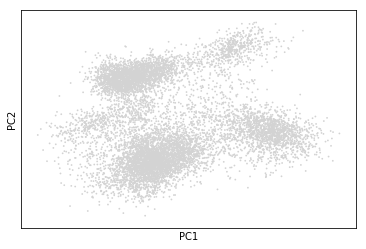

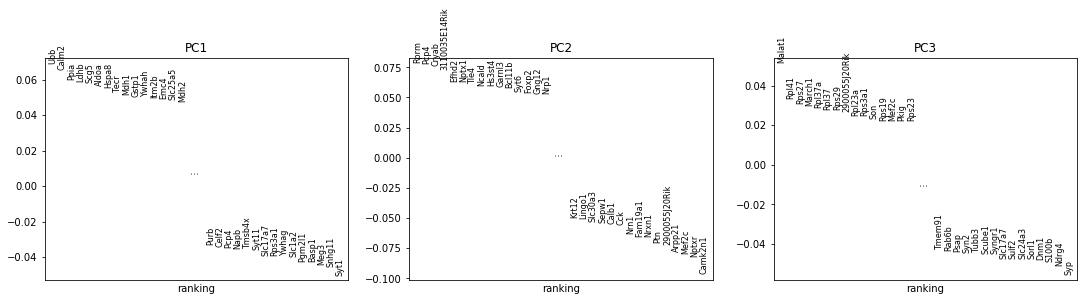

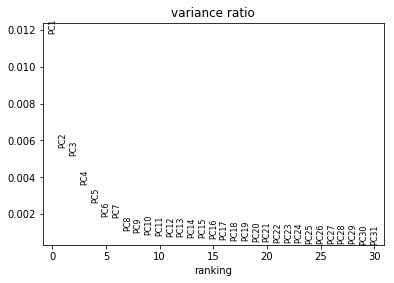

In [59]:
# reduce the dimensions in the merged dataset
sc.pp.pca(adata_corr)
sc.pl.pca_overview(adata_corr)

We are here again visualizng with a PCA scatter plot how well the two datasets are aligning after MNN batch correction and can see that the datasets are aligning better. From here, the data dimensions are further reduced and the connectivity computed using UMAP.

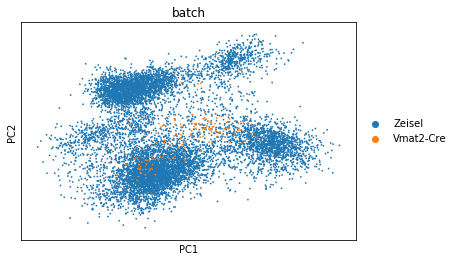

In [60]:
# visualize the data with UMAP. Save file
sc.pl.pca(adata_corr, color = 'batch',save = 'umap_zeisel_Vmat2_procc.pdf')

In [135]:
# compute neighborhood graph and UMAP coordinates
sc.pp.neighbors(adata_corr, n_neighbors= 10, n_pcs= 9)
sc.tl.umap(adata_corr)

C:\Users\hanwe868\AppData\Roaming\Python\Python36\site-packages\numba\typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "..\..\..\AppData\Local\Continuum\anaconda3\lib\site-packages\umap\rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
C:\Users\hanwe868\AppData\Roaming\Python\Python36\site-packages\numba\typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "..\..\..\AppData\

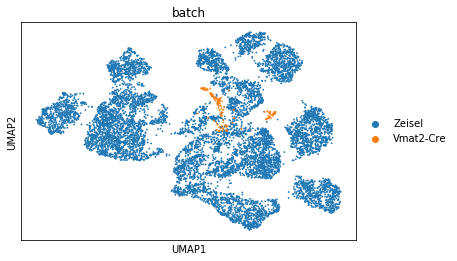

In [136]:
# visualize the data with UMAP. Save file
sc.pl.pca(adata_corr, color = 'batch',save = 'umap_zeisel_Vmat2_procc.pdf')

Visualize the data based in the probable location annotation from Zeisel et al. The Vmat2-Cre neurons are visualized in the 'nan' category

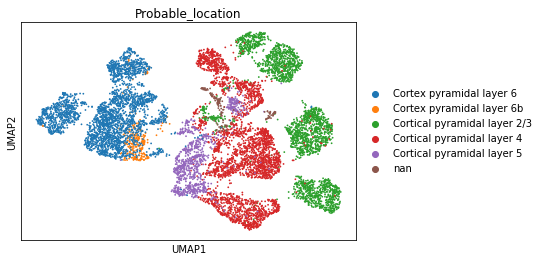

In [137]:
sc.pl.umap(adata_corr, color = 'Probable_location',save = 'umap_zeisel_Vmat2_loc_procc.pdf')
#make the observation names unique
adata_corr.obs_names_make_unique()
adata_corr.var_names_make_unique()

In [138]:
# calculate the number of cells that belong to each category
print(calc_celltype_observation(adata_corr, 'Probable_location'))

                              number_cells
obs_name                                  
Cortex pyramidal layer 6              2765
Cortex pyramidal layer 6b              273
Cortical pyramidal layer 2/3          2421
Cortical pyramidal layer 4            3048
Cortical pyramidal layer 5             862
nan                                    151


Here we are training an SGD classifier on the Zeisel data and use the trained model on the Vmat2-Cre dataset to predict the location annotations for these cells

In [139]:
# create a training dataset from Zeisel et al dataset. Use expression as predictor variables and the annotated location as target labels
train_X = adata_corr.X[adata_corr.obs["batch"] == "Zeisel", :]
train_y = adata_corr.obs["Probable_location"][adata_corr.obs["batch"] == "Zeisel"].values
# create a test dataset from the Vmat2-Cre for prediction
test_X = adata_corr.X[adata_corr.obs["batch"] == "Vmat2-Cre", :]

In [156]:
from sklearn import linear_model
#evaluating linear SGDClassifier
model_sgd = linear_model.SGDClassifier(max_iter=1000, tol=1e-3, loss = 'log')
model_sgd.fit(train_X, train_y)
print('SDGClassifier:', (model_sgd.score(train_X, train_y)))
labels = model_sgd.predict(test_X)
prob = model_sgd.predict_proba(adata_corr.X)

SDGClassifier: 0.9758778951862526


In [157]:
# add observation for the predicted labels
adata_corr.obs["Probable_location"][adata_corr.obs["batch"] == "Vmat2-Cre"] = labels
# add probability for each assigned location as observation
prob = np.max(prob, axis = 1)
adata_corr.obs["probability"] = prob

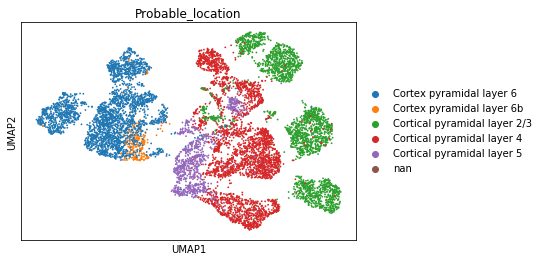

In [158]:
# display the data with Vmat2-Cre annotated locations
sc.pl.umap(adata_corr, color = 'Probable_location', save = 'umap_zeisel_vmat2_batch_anntotated_procc.pdf')

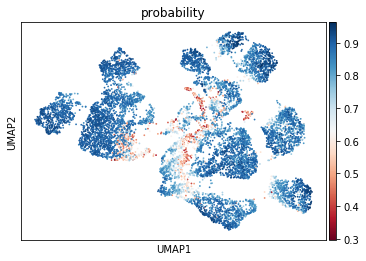

In [159]:
# display the probabilities for the assigned locations
sc.pl.umap(adata_corr, color = 'probability', color_map = 'RdBu', save = 'umap_zeisel_vmat2_probability_procc.pdf')

After assigning the Vmat2-Cre population the Zeisel annotated location labels and calculating the probability scores, we are here showing the distribution of probability scores. From the graph, it can be seen that the probabilty scores were rather low, which could be explained by batch effects due to technical differences in dissociation protocol, different sensitivity of the single-cell sequencing methods and as the Zeisel data is consisting of cortical neurons from the whole telencephalon, that the Vmat2 population was not captured

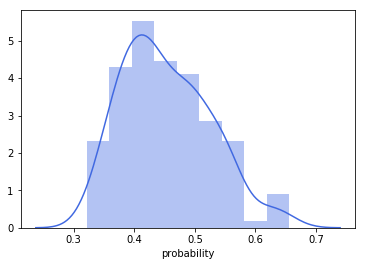

In [160]:
# show the distribution of probability scores in the Vmat2-Cre population
adata_corr_vmat2 = adata_corr[adata_corr.obs['batch'] == 'Vmat2-Cre']
distplot_prob_loc = sns.distplot(adata_corr_vmat2.obs['probability'])
plt.show()
fig = distplot_prob_loc.get_figure()
fig.savefig('distplot_prob_loc.pdf')

The annotated probable locations are mapped back to the original Vmat2-Cre datafile and are vizualized

In [161]:
# add the observational names from the corrected Vmat2 datafile to the original Vmat2 dataset. Add probable location annotations
adata_w.obs_names = adata_corr_vmat2.obs_names
adata_w.obs_names
adata_w.obs['Probable_location'] = adata_corr_vmat2.obs['Probable_location']

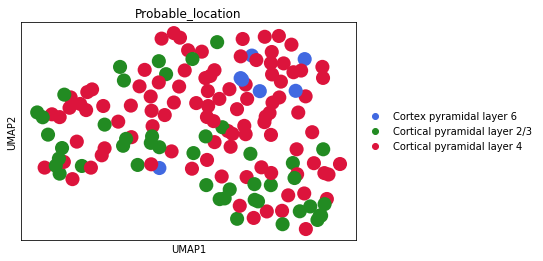

In [162]:
colors_loc = ['royalblue', 'forestgreen', 'crimson']
sns.set_palette(sns.color_palette(colors_loc))
sc.pl.umap(adata_w, color='Probable_location', palette= colors_loc, save = 'umap_vmat2_annotated_locations.pdf')

In [163]:
calc_Vmat = calc_celltype_observation(adata_w, 'Probable_location')
print(calc_Vmat)

print((calc_Vmat/len(adata_w.obs_names))*100)

                              number_cells
obs_name                                  
Cortex pyramidal layer 6                 7
Cortical pyramidal layer 2/3            45
Cortical pyramidal layer 4              99
                              number_cells
obs_name                                  
Cortex pyramidal layer 6          4.635762
Cortical pyramidal layer 2/3     29.801325
Cortical pyramidal layer 4       65.562914


Now we are vizualizing the Zeisel et al annotated clusters in the merged dataset. We are repeating the process of training an SGD classifier on the Zeisel data and use the trained model on the Vmat2-Cre dataset to predict in this case, the cluster annotations of the Vmat2-Cre neurons

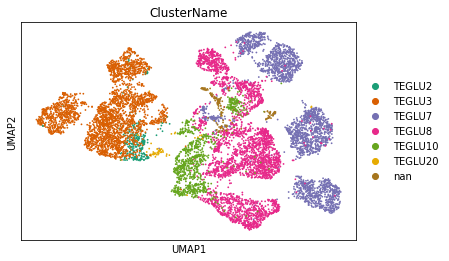

In [164]:
colors = sns.palettes.color_palette("Dark2", n_colors=7)
sc.pl.umap(adata_corr, color = 'ClusterName', palette = colors, save = 'umap_zeisel_Vmat2_cluster_procc.pdf')
#make the observation names unique
adata_corr.obs_names_make_unique()
adata_corr.var_names_make_unique()

In [229]:
# create testing datasets
train_X_2 = adata_corr.X[adata_corr.obs["batch"] == "Zeisel", :]
train_y_2 = adata_corr.obs["ClusterName"][adata_corr.obs["batch"] == "Zeisel"].values
test_X_2 = adata_corr.X[adata_corr.obs["batch"] == "Vmat2-Cre", :]

In [236]:
#evaluating linear SGDClassifier
model_sgd = linear_model.SGDClassifier(max_iter=1000, tol=1e-3, loss = 'log')
model_sgd.fit(train_X_2, train_y_2)
print('SDGClassifier:', (model_sgd.score(train_X_2, train_y_2)))
labels_2 = model_sgd.predict(test_X_2)
prob_2 = model_sgd.predict_proba(adata_corr.X)

SDGClassifier: 0.9796136193830718


In [237]:
prob_2 = np.max(prob_2, axis = 1)

In [238]:
adata_corr.obs["ClusterName"][adata_corr.obs["batch"] == "Vmat2-Cre"] = labels_2
adata_corr.obs["probability_2"] = prob_2

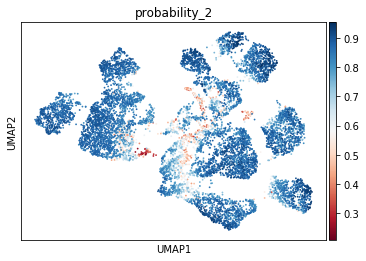

In [239]:
sc.pl.umap(adata_corr, color = 'probability_2', color_map = 'RdBu', save = 'umap_zeisel_vmat2_probability_cluster.pdf')

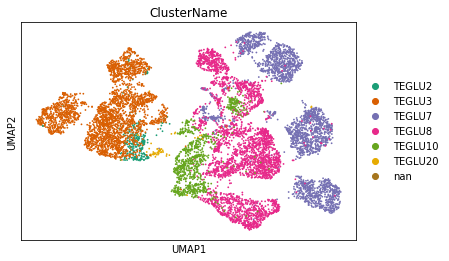

In [240]:
sc.pl.umap(adata_corr, color = 'ClusterName', palette = colors, save = 'umap_zeisel_vmat2_cluster_annot.pdf')

In [241]:
adata_corr_vmat2_2 = adata_corr[adata_corr.obs['batch'] == 'Vmat2-Cre']
adata_w.obs_names = adata_corr_vmat2_2.obs_names
adata_w.obs_names

adata_w.obs['ClusterName'] = adata_corr_vmat2_2.obs['ClusterName']
calc_Vmat_cluster = calc_celltype_observation(adata_w, 'ClusterName')
print(calc_Vmat_cluster)

print((calc_Vmat_cluster/len(adata_w.obs_names))*100)

          number_cells
obs_name              
TEGLU3               5
TEGLU7              42
TEGLU8             104
          number_cells
obs_name              
TEGLU3        3.311258
TEGLU7       27.814570
TEGLU8       68.874172


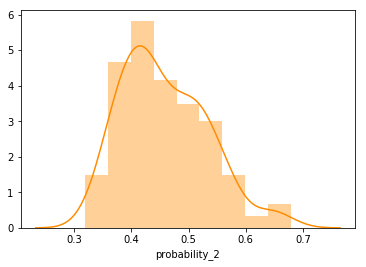

In [242]:
distplot_prob_cluster = sns.distplot(adata_corr_vmat2_2.obs['probability_2'],kde = True, norm_hist= True)
plt.show()
fig_cluster = distplot_prob_cluster.get_figure()
fig_cluster.savefig('distplot_prob_cluster.pdf')

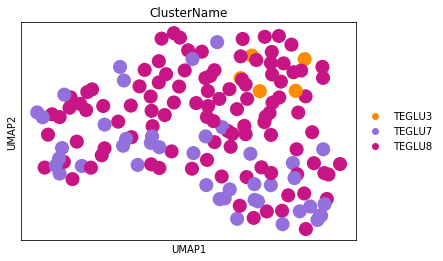

In [243]:
colors_clu = ['darkorange', 'mediumpurple', 'mediumvioletred', 'yellowgreen']
sns.set_palette(sns.color_palette(colors_clu))
sc.pl.umap(adata_w, color='ClusterName', palette= colors_clu, save = 'umap_vmat2_annotated_clusters.pdf')